### Import libraries

In [779]:
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
%matplotlib inline
import re

#### Read from the input tweet file and assign column names

In [804]:
input_file_sentiment="E:\\python_projects\\Springboard\datasets\\twitter_sentiment140\\training_140_sentiment.csv"

In [805]:
#input_file_airline="E:\\python_projects\\Springboard\\datasets\\twitter_airline_sentiment\\Tweets.csv"

In [806]:
sentiment_colls=['sentiment','tweet_id','tweet_date','query','username','tweet']
tweet_df=pd.read_csv(input_file_sentiment,encoding='cp1252',names=sentiment_colls,usecols=['sentiment','tweet'])
#airline_df=pd.read_csv(input_file_airline,usecols=[1,10],names=['sentiment','tweet'],header=0)
#tweet_df=pd.concat([sentiment_df,airline_df])

In [807]:
tweet_df.shape

(1600000, 2)

In [808]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
tweet        1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [809]:
np.sum(tweet_df.isnull())

sentiment    0
tweet        0
dtype: int64

#### Value counts on the output sentiment

In [810]:
tweet_df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

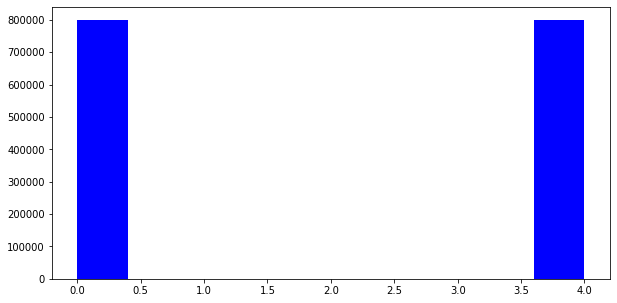

In [813]:
fig,ax=plt.subplots(figsize=(10,5))
ax.hist(tweet_df.sentiment,color='blue')
plt.show()

In [814]:
df_cleaned=tweet_df[['tweet','sentiment']]


#### Adding stopwords from nltk and removing 'no' and 'not' from stopwords

In [671]:
stopwords_default=stopwords.words('english')

In [672]:
stopwords_updated=[word for word in stopwords_default if word not  in ['no','not'] ]


#### Cleanse Tweets to remove punctuations,@, urls

In [690]:
def cleanse_tweet(line):
    #remove any @ words
    tweet_no_refs=re.sub(r'@\S+|#\S+','',line)

    #remove any non alphanumeric character like or punctuations
    tweet_no_punctuation=re.sub(r'[^\w\s]','',tweet_no_refs)

    #remove url links
    tweet_no_urls=re.sub(r'https?\S+','',tweet_no_punctuation)  
       
    #remove numerals
    tweet_no_numerals=re.sub(r'[0-9]+','',tweet_no_urls)

    #remove stopwords
    tweet_stopwords=" ".join([word.lower() for word in tweet_no_numerals.split() if word not in stopwords_updated])
        
    return tweet_stopwords
    

In [693]:
df_cleaned['tweet_cleaned']=df_cleaned['tweet'].apply(lambda tweet:cleanse_tweet(tweet))
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized,tweet_stem,tweet_lemma
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david...","[awww, that, bummer, you, shoulda, got, david,...",awww that bummer you shoulda got david carr th...
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might...","[upset, cant, updat, facebook, text, might, cr...",upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t...","[i, dive, mani, time, ball, manag, save, the, ...",i dive mani time ball manag save the rest go b...
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]","[no, not, behav, im, mad, i, cant, see]",no not behav im mad i cant see
...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling...","[just, woke, have, no, school, best, feel, ever]",just woke have no school best feel ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter...","[thewdbcom, veri, cool, hear, old, walt, inter...",thewdbcom veri cool hear old walt interview â
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]","[are, readi, mojo, makeov, ask, detail]",are readi mojo makeov ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ...","[happi, th, birthday, boo, alll, time, tupac, ...",happi th birthday boo alll time tupac amaru sh...


#### Tokenizing tweets

In [696]:
df_cleaned['tweet_tokenized']=df_cleaned['tweet_cleaned'].apply(lambda tweet:word_tokenize(tweet))

In [679]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david..."
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might..."
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t..."
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]"
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]"
...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ..."


#### Stemming tweets

In [680]:
def tweet_stemming(tweet):
     return [SnowballStemmer('english').stem(word) for word in tweet]

In [700]:
df_cleaned['tweet_stem']=df_cleaned['tweet_tokenized'].apply(lambda tweet:tweet_stemming(tweet))

In [682]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized,tweet_stem
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david...","[awww, that, bummer, you, shoulda, got, david,..."
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might...","[upset, cant, updat, facebook, text, might, cr..."
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t...","[i, dive, mani, time, ball, manag, save, the, ..."
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]"
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]","[no, not, behav, im, mad, i, cant, see]"
...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling...","[just, woke, have, no, school, best, feel, ever]"
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter...","[thewdbcom, veri, cool, hear, old, walt, inter..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]","[are, readi, mojo, makeov, ask, detail]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ...","[happi, th, birthday, boo, alll, time, tupac, ..."


#### Lemmatizing tweets

In [683]:
def tweet_lemmatize(tweet):
    return ' '.join(WordNetLemmatizer().lemmatize(word) for word in tweet)

In [684]:
df_cleaned['tweet_lemma']=df_cleaned['tweet_stem'].apply(lambda tweet:tweet_lemmatize(tweet))

In [685]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized,tweet_stem,tweet_lemma
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david...","[awww, that, bummer, you, shoulda, got, david,...",awww that bummer you shoulda got david carr th...
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might...","[upset, cant, updat, facebook, text, might, cr...",upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t...","[i, dive, mani, time, ball, manag, save, the, ...",i dive mani time ball manag save the rest go b...
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]","[no, not, behav, im, mad, i, cant, see]",no not behav im mad i cant see
...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling...","[just, woke, have, no, school, best, feel, ever]",just woke have no school best feel ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter...","[thewdbcom, veri, cool, hear, old, walt, inter...",thewdbcom veri cool hear old walt interview â
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]","[are, readi, mojo, makeov, ask, detail]",are readi mojo makeov ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ...","[happi, th, birthday, boo, alll, time, tupac, ...",happi th birthday boo alll time tupac amaru sh...


#### Tweet Vectorization

In [697]:
vectorizer=TfidfVectorizer(ngram_range=(1,2),max_features=500000)
df_X=vectorizer.fit_transform(df_cleaned['tweet_lemma'])


In [698]:
y=df_cleaned['sentiment'].apply(lambda x:1 if x==4 else x)
y


0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: sentiment, Length: 1600000, dtype: int64

#### Split into train and test

In [699]:
X_train,X_test,y_train,y_test=train_test_split(df_X,y,test_size=0.3,random_state=40)

### Train, Predict and model Matrixes

In [ ]:
def model_evaluate(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(f'accuracy score: {accuracy_score(y_test,y_pred)}')
    print(classification_report(y_test,y_pred))
    conf_matrix=confusion_matrix(y_test,y_pred)
    print(f'confusion_matrix\n')
    print(f'True Negetives: {conf_matrix[0][0]}')
    print(f'False Negetive{conf_matrix[0][1]}')
    print(f'False Positive{conf_matrix[1][0]}')
    print(f'True Positive{conf_matrix[1][1]}')
    
   
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    auc_roc=auc(fpr,tpr)
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    fig.tight_layout(pad=6)
    ax[0].plot(fpr,tpr,color='green',label='ROC Curve(area under curve : %0.00f)'% auc_roc)
    
    ax[0].set(title='ROC Curve',xlabel='False Positive Rate',ylabel='True Positive Rate')
    ax[0].grid(True)
    ax[1]=sns.heatmap(conf_matrix,cmap='Blues')
    ax[1].set(title='Confusion Matrix',ylabel='Actual Values',xlabel='Predicted Values')
    plt.show()
    

#### Logistic Regression Model

accuracy score: 0.8079458333333334
              precision    recall  f1-score   support

           0       0.82      0.79      0.80    239943
           1       0.80      0.82      0.81    240057

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

confusion_matrix[[190277  49666]
 [ 42520 197537]]


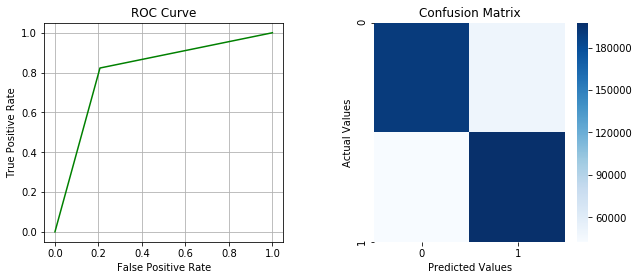

In [815]:
lrmodel=LogisticRegression()
model_evaluate(lrmodel)

#### Support Vector Classification

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy score: 0.7912291666666667
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    239943
           1       0.79      0.80      0.79    240057

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000

confusion_matrix[[187213  52730]
 [ 47480 192577]]


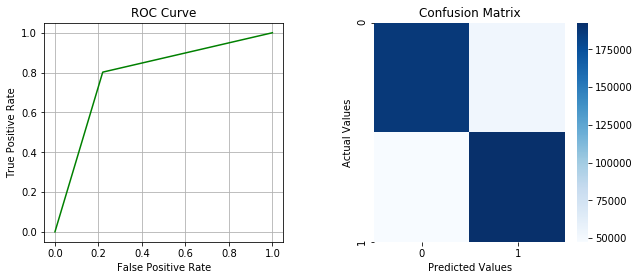

In [817]:
svcmodel=LinearSVC()
model_evaluate(svcmodel)

#### Naive Bayes classifier

accuracy score: 0.7886083333333334
              precision    recall  f1-score   support

           0       0.80      0.77      0.78    239943
           1       0.78      0.81      0.79    240057

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000

confusion_matrix[[184104  55839]
 [ 45629 194428]]


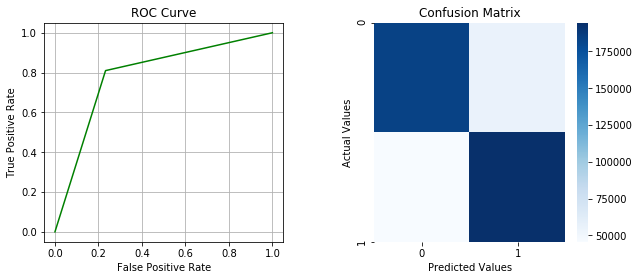

In [816]:
nbmodel=BernoulliNB()
model_evaluate(nbmodel)